# FastAI Tabular Data Neural Network

Attempt to get fastai.tabular_learner() to solve this linear regression problem.

- layers=[200,100,50]  + fit_one_cycle(150) - Kaggle score is 3.25917 (terrible) and most predictions are an order of magnitude too low
- layers=[1000,200,50] + fit_one_cycle(20)  - Kaggle score is 2.43697 (terrible)
- layers=[100, 50]     + fit_one_cycle(20)  - Kaggle score is 1.04220 (terrible) 
- layers=[100, 50]     + fit_one_cycle(200) - Kaggle score is 1.04220 (terrible) 
- layers=[50]          + fit_one_cycle(200) - Kaggle score is 1.04220 (terrible) 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai
from fastai.basic_data import DatasetType
from fastai.tabular.data import TabularDataBunch, TabularList
from fastai.tabular.transform import FillMissing, Categorify, Normalize
from fastai.tabular.learner import tabular_learner
from fastai.metrics import accuracy, r2_score, root_mean_squared_error, mean_squared_logarithmic_error
from fastai.data_block import FloatList
import numpy as np
import pandas as pd
import random
import pydash
import torch

# from fastai.structured import *
# np.set_printoptions(threshold=50, edgeitems=20)

In [3]:
fastai.torch_core.defaults.device = 'cpu'

In [4]:
df = pd.read_csv('data/train.csv')
df.SalePrice = df.SalePrice.astype(float); # Float implies a regression problem rather than categorization 
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [5]:
test_df = pd.read_csv('data/test.csv').fillna(0)
test_df['SalePrice'] = 0.0
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,0,Reg,Lvl,AllPub,...,0,0,MnPrv,0,0,6,2010,WD,Normal,0.0
1,1462,20,RL,81.0,14267,Pave,0,IR1,Lvl,AllPub,...,0,0,0,Gar2,12500,6,2010,WD,Normal,0.0
2,1463,60,RL,74.0,13830,Pave,0,IR1,Lvl,AllPub,...,0,0,MnPrv,0,0,3,2010,WD,Normal,0.0
3,1464,60,RL,78.0,9978,Pave,0,IR1,Lvl,AllPub,...,0,0,0,0,0,6,2010,WD,Normal,0.0
4,1465,120,RL,43.0,5005,Pave,0,IR1,HLS,AllPub,...,0,0,0,0,0,1,2010,WD,Normal,0.0


In [6]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
procs = [FillMissing, Categorify, Normalize]
cat_names = [
    'CentralAir',
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
    'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC',
    "MoSold",
    "LandSlope", "MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities",
    "LotConfig", "Neighborhood", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "MasVnrType", "Foundation",
    "BsmtExposure", "Heating", "Functional", "GarageFinish", "Fence", "SaleType", "SaleCondition",
    "MiscFeature", "Electrical", "GarageType", "PavedDrive",
    "Condition1", "Condition2",
    "Exterior1st", "Exterior2nd",
    "BsmtFinType1", "BsmtFinType2",
]
cont_names = [ x for x in df.columns if x not in cat_names ]

In [8]:
valid_idx  = random.sample( range(0, len(df)), len(df)//5)

In [9]:
# max_log_y = np.log( np.max(df['SalePrice'])*1.2 )
max_y   = np.max(df['SalePrice'])*1.2
y_range = torch.tensor([0, max_y])

In [10]:
data = TabularDataBunch.from_df(
    './data/', df, 
    dep_var='SalePrice', 
    valid_idx=valid_idx,
    test_df=test_df,
    procs=[FillMissing, Categorify, Normalize], 
    cat_names=cat_names,
    cont_names=cont_names,
)
# data.add_test(TabularList.from_df(
#     test_df,
#     procs=[FillMissing, Categorify, Normalize],     
#     cat_names=cat_names,
#     cont_names=cont_names,
# ))
# data

In [11]:
# NOTE: root_mean_squared_error throes AssertionError: Expected output and target to have the same number of elements but got 36608 and 64.
#       but only when SalesPrice is int for categorization and not float for regression
learn = tabular_learner(data=data, layers=[50], 
   metrics=[mean_squared_logarithmic_error], 
#  use_bn=False,
   y_range=y_range
)
# learn

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


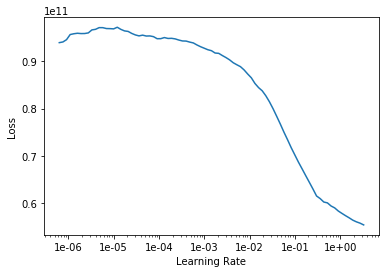

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(20, 1e-01)

epoch,train_loss,valid_loss,mean_squared_logarithmic_error,time
0,64249749504.000000,24976607232.000000,0.583556,00:02
1,32929581056.000000,22362542080.000000,9.374663,00:02
2,19912996864.000000,5972129280.000000,0.371259,00:02
3,12592592896.000000,2216204032.000000,0.060021,00:02
4,8497361920.000000,3054604288.000000,0.062146,00:02
5,5961804800.000000,358732928.000000,0.018577,00:02
6,4224052224.000000,274273472.000000,0.014936,00:02
7,2986714624.000000,211608064.000000,0.009878,00:02
8,2431450368.000000,1016940096.000000,0.036632,00:02
9,1892895232.000000,255055808.000000,0.010394,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


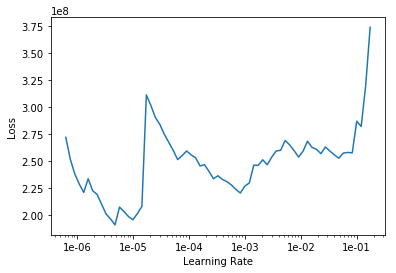

In [22]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(10, 1e-04)

epoch,train_loss,valid_loss,mean_squared_logarithmic_error,time
0,306300480.000000,63852832.000000,0.005427,00:02
1,311492448.000000,63610528.000000,0.005079,00:03
2,246503488.000000,63080168.000000,0.005308,00:03
3,297215104.000000,82372536.000000,0.005713,00:03
4,293507680.000000,63607584.000000,0.004916,00:03
5,304315776.000000,67048944.000000,0.005535,00:03
6,283598048.000000,65206356.000000,0.005670,00:03
7,315618368.000000,63052632.000000,0.005375,00:03
8,278145600.000000,67040208.000000,0.005666,00:03
9,278525600.000000,71519792.000000,0.005945,00:03


In [23]:
preds = learn.get_preds(ds_type=DatasetType.Test)[0].numpy().flatten(); preds
submission_df = pd.DataFrame({
    'Id':        test_df['Id'], 
    'SalePrice': preds
})
submission_df.to_csv('data/submissions/fastai.csv', header=True, index=False)
submission_df.head()

,Id,SalePrice
0,1461,76557.187500
1,1462,86541.820312
2,1463,89579.953125
3,1464,92277.421875
4,1465,91886.476562


# Submit to Kaggle

```
kaggle competitions submit -c house-prices-advanced-regression-techniques -f data/submissions/fastai.csv -m "Fastai tabular_learner"
```